# 3rd_Cupoy ML 100 marathon Final exam


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os 
from os import listdir
from os.path import isfile, join
import shutil
import pandas as pd 
import numpy as np
import random
import zipfile
from tqdm import tqdm
import cv2

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
import tensorflow as tf


Using TensorFlow backend.


In [0]:
path = '/content/drive/My Drive/課程/100daysML/ml100-03-final.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('ml100-03-final')

## Data Preprocessing

In [4]:
train_path = '/content/ml100-03-final/ml100-03-final/image_data/train'
flower = [f for f in listdir(train_path)][:-1]
flower

['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']

In [0]:
daisy_dir = train_path+'/daisy'
sunflower_dir = train_path+'/sunflower'
tulip_dir = train_path+'/tulip'
dandelion_dir = train_path+'/dandelion'
rose_dir = train_path+'/rose'

### Convert images to numpy arrays

In [0]:
def assign_label(img, flower_type):
  return flower_type

def make_train_data(train, labels, img_size, flower_type, DIR):
  for img in tqdm(os.listdir(DIR)):
    label = assign_label(img, flower_type)
    path = os.path.join(DIR, img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    
    train.append(np.array(img))
    labels.append(str(label))

In [0]:
train = []
flower_label = []
img_size = (224, 224)

In [8]:
make_train_data(train, flower_label, img_size, 'Daisy', daisy_dir)
make_train_data(train, flower_label, img_size, 'Sunflower',sunflower_dir)
make_train_data(train, flower_label, img_size, 'Tulip',tulip_dir)
make_train_data(train, flower_label, img_size, 'Dandelion',dandelion_dir)
make_train_data(train, flower_label, img_size, 'Rose',rose_dir)

100%|██████████| 515/515 [00:01<00:00, 454.83it/s]


In [9]:
print(len(train))
print(len(flower_label))

2823
2823


### Label encoding and One-hot encoding

In [0]:
num_classes = 5

le = LabelEncoder()
labels = le.fit_transform(flower_label)
labels = to_categorical(labels, num_classes) # one hot encoding

train = np.array(train) 
train = train/255 # normalization

### Split train and validation set

In [0]:
# split train set into train and validation
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.25, random_state=42)

## Data Visualization

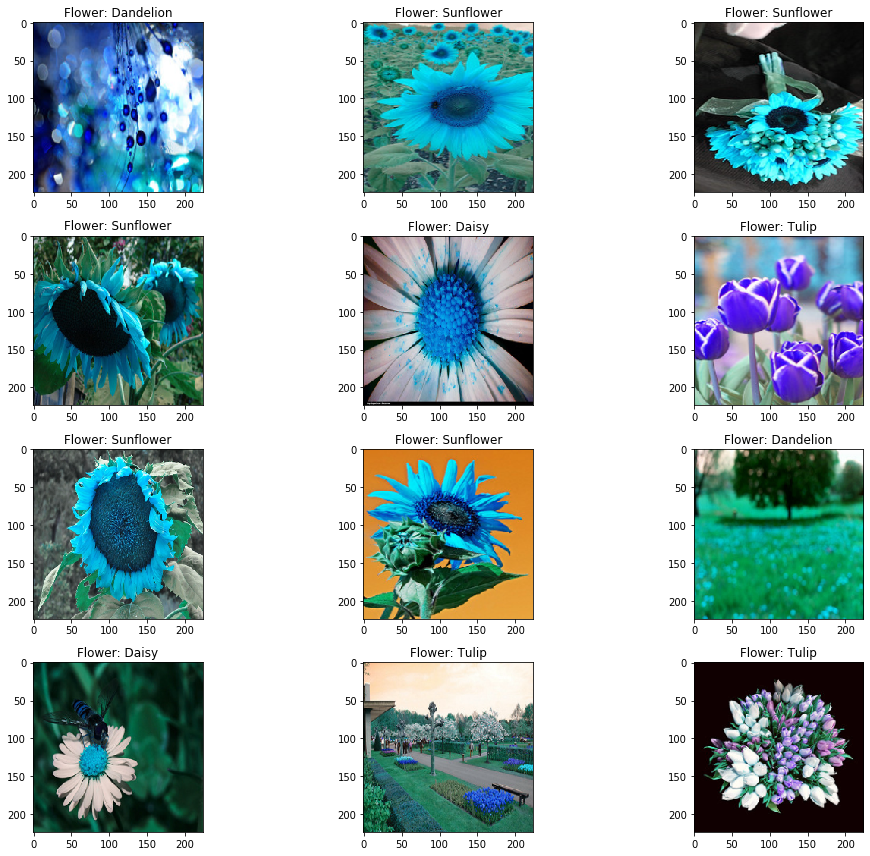

In [46]:
fig,ax = plt.subplots(4,3)
fig.set_size_inches(15,12)
for i in range(4):
    for j in range (3):
        l = random.randint(0, len(train))
        ax[i,j].imshow(train[l])
        ax[i,j].set_title('Flower: '+flower_label[l])
        
plt.tight_layout()

## Data Augmentation Example

In [0]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [0]:
img = load_img(train_path+'/rose/da6bf5bdc0b401098d42c8817b41e89e.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
preview_path = '/content/drive/My Drive/課程/100daysML/ml100-03-final/image_data/preview'
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=preview_path, save_prefix='rose', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

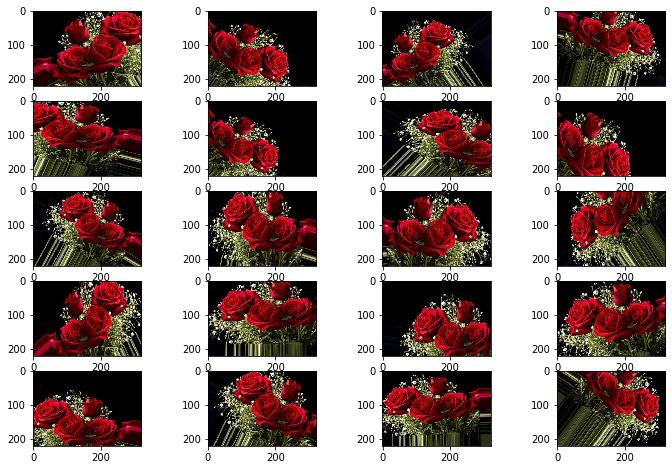

In [0]:
w=10
h=10
fig=plt.figure(figsize=(12, 8))
columns = 4
rows = 5

preview = [f for f in listdir(preview_path) if isfile(join(preview_path, f))]

for i in range(1, columns*rows +1):
    img = Image.open(preview_path+'/'+preview[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Model Training
[Pre-trained Model Tutorial](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

### Build a Model

In [0]:
# dimensions of our images.
img_width, img_height = 224, 224

nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [19]:
# VGG in Sequential Model
model = Sequential()
model.add(VGG16(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 21,138,757
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### Data Augmentation

In [0]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [24]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_test, y_test),
                              verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size)

# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
132/132 [==============================] - 30s 227ms/step - loss: 1.7853 - acc: 0.2374 - val_loss: 1.6041 - val_acc: 0.2479
Epoch 2/50
132/132 [==============================] - 24s 178ms/step - loss: 1.6038 - acc: 0.2407 - val_loss: 1.5978 - val_acc: 0.2479
Epoch 3/50
132/132 [==============================] - 24s 181ms/step - loss: 1.5961 - acc: 0.2432 - val_loss: 1.5753 - val_acc: 0.2479
Epoch 4/50
132/132 [==============================] - 25s 188ms/step - loss: 1.5717 - acc: 0.2857 - val_loss: 1.5313 - val_acc: 0.3414
Epoch 5/50
132/132 [==============================] - 24s 183ms/step - loss: 1.5216 - acc: 0.2993 - val_loss: 1.3791 - val_acc: 0.4079
Epoch 6/50
132/132 [==============================] - 23s 177ms/step - loss: 1.3828 - acc: 0.3889 - val_loss: 1.3194 - val_acc: 0.3839
Epoch 7/50
132/132 [==============================] - 23s 175ms/step - loss: 1.4154 - acc: 0.3718 - val_loss: 1.5970 - val_acc: 0.2337
Epoch 8/50
132/132 [==============================] - 2

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.37601676110505383
Test accuracy: 0.9121813031161473


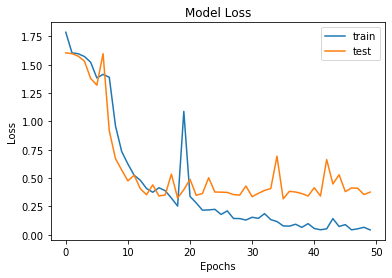

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

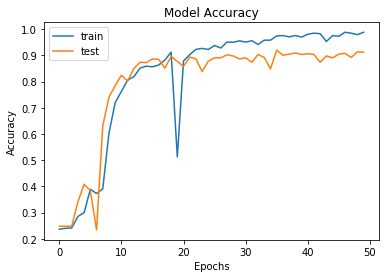

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [0]:
# save model 
model.save_weights('first_try.h5')  

## Predict Test Set

In [34]:
test = []
img_size = (224, 224)
test_path = '/content/ml100-03-final/ml100-03-final/image_data/test'
def make_test_data(test, img_size, DIR):
  for img in tqdm(os.listdir(DIR)):
    path = os.path.join(DIR, img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    
    test.append(np.array(img))

make_test_data(test, img_size, test_path)

100%|██████████| 2000/2000 [00:04<00:00, 487.12it/s]


In [0]:
test = np.array(test) 
test = test/255 # normalization

In [0]:
# getting predictions on test set.
pred = model.predict(test)
pred_digits = np.argmax(pred, axis=1)

In [39]:
pred_digits

array([2, 4, 1, ..., 0, 1, 1])

In [0]:
filename = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [0]:
df = pd.DataFrame(list(zip(filename, pred_digits)), columns =['id', 'flower_class'])
df['id'] = df['id'].str.replace('.jpg', '')

In [46]:
df.head()

,id,flower_class
0,0bfd70207c02f6fc77f4835468024c2a,2
1,27cb1939d202689334de4f53b0e33a41,4
2,138506e5ea273cb5d99c9957b02ee37d,1
3,08a4c95527bb9bdc648c0272624c2b92,4
4,aa4d89923d74bc247b29b306b62c2662,0


In [44]:
# flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

'id,flower_class\n0bfd70207c02f6fc77f4835468024c2a.jpg,2\n27cb1939d202689334de4f53b0e33a41.jpg,4\n138506e5ea273cb5d99c9957b02ee37d.jpg,1\n08a4c95527bb9bdc648c0272624c2b92.jpg,4\naa4d89923d74bc247b29b306b62c2662.jpg,0\nf9745be00ab758aff6cb7272d1d6d625.jpg,0\nc90b3b446fe3fa178471254117dafe10.jpg,4\nc4cf85bc0fb71fcf61128580493c4f66.jpg,1\ne86789078f3731bdc3d1e740825f29b3.jpg,3\nc4849a51f75a76ba25a1cd55fa48a649.jpg,4\na77cff5c02766935e73241222a72e008.jpg,2\nb0285eee6c90d102a05a2e2db53a7130.jpg,3\nc313fd03eb9513bc25f782607b625c81.jpg,1\nc2e769f168fe0bc3062fc81a62969a97.jpg,3\n575e3afab9b5af95c7a3073549833bf2.jpg,4\n7baf51ae88cf50cd058225640feebf68.jpg,3\n930619d1c7dbc1d46e28742a1fafee4d.jpg,4\n0899def3ea7f58ee950f6bd1d6061bea.jpg,3\n43b56f8d2a7dbc8c69a98f002fea9879.jpg,2\nc4c119e3e6afda90b43e844fc7d725a3.jpg,1\ne3da47c37524e4654bb0e1ada633151f.jpg,2\n45941dd36c8ce5639c55a41e1e929ce6.jpg,4\n86ee7ac1665cb42c6a1df5b5745d9d83.jpg,1\n99df788efd73f9909501a3f9658cc528.jpg,3\n4eec5ef91646206b37547d

In [47]:
os.getcwd()

'/content'

In [0]:
df.to_csv('result.csv', index=False, header=True)